In [1]:
try:
    from google.colab import drive
except ModuleNotFoundError:
    IN_COLAB = False
else:
    drive.mount('/content/drive')
    IN_COLAB = True

In [2]:
if IN_COLAB:
    REF_PATH = "/content/drive/MyDrive/Project/"
else:
    REF_PATH = "../../data/"
REF_PATH += "Average pm25 per neighborhood BASELINE Taxi.csv"

In [3]:
if IN_COLAB:
    TRIPS_PATH = "/content/drive/MyDrive/Project/"
else:
    TRIPS_PATH = "../../data/"
TRIPS_PATH += "nyc1.csv"

In [4]:
POLYGON_PATH = 'https://raw.githubusercontent.com/IsamAljawarneh/datasets/1c2a6af7dea7aa93105ac1d1d0118d07bd681d8a/data/nyc_polygon.geojson'

In [5]:
import pandas as pd
import folium
import geopandas as gpd
from datetime import datetime
import numpy as np
from shapely.geometry import Polygon
import math
import matplotlib.pyplot as plt
from shapely import wkt

from s2 import s2

In [6]:
s2_resolution = 14

In [7]:
trips = pd.read_csv(TRIPS_PATH)
# Filter trips with corresponding neighborhoods in NYC
trips = gpd.sjoin(
    gpd.GeoDataFrame(trips, geometry=gpd.points_from_xy(trips.Pickup_longitude, trips.Pickup_latitude), crs='epsg:4326'),
    gpd.read_file(POLYGON_PATH)
)[list(trips.columns) + ["neighborhood"]]

In [8]:
trips['s2'] = trips.apply(lambda x: s2.geo_to_s2(x.Pickup_latitude, x.Pickup_longitude, s2_resolution), axis = 1)

In [9]:
def calculate_rmse(predicted_values, actual_values):
    # Calculate squared differences
    squared_diff = (predicted_values - actual_values) ** 2
    
    # Calculate mean squared differences
    mean_squared_diff = np.mean(squared_diff)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_diff)
    
    return rmse

# Stratified Sampling

## <font color = 'blue'> Fixed Resolution and Variable Size </font>

### <font color = 'green'>- RMSE </font>

In [10]:
population_pm25 = (trips
                .groupby('neighborhood')
                .Total_amount
                .agg(list)
                .to_frame("Total_amount_list")
                .reset_index())  # Make a list of pm25 values for each neighborhood

population_pm25['Overall_amount'] = population_pm25['Total_amount_list'].apply(lambda x: sum(x))  # Find the average pm25 value per neighborhood
population_pm25.drop('Total_amount_list', axis = 1, inplace=True)

max_values = population_pm25['Overall_amount'].max()
population_pm25['Overall_amount'] *= 1000
population_pm25['Overall_amount'] /= max_values

population_pm25.sort_values(by='neighborhood', inplace=True)
population_pm25.reset_index(drop=True, inplace=True)

In [11]:
def perform_test():
    error = []
    sample_size_range = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    for sampling_frequency in sample_size_range:
        stratified_sample = trips.groupby('s2').apply(lambda x: x.sample(frac = sampling_frequency)).reset_index(drop=True)
        random_sample_pm25 = (stratified_sample
                    .groupby('neighborhood')
                    .Total_amount
                    .agg(list)
                    .to_frame("Total_amount_list")
                    .reset_index())  # Make a list of pm25 values for each neighborhood
        random_sample_pm25['Overall_amount'] = random_sample_pm25['Total_amount_list'].apply(lambda x: sum(x))  # Find the average pm25 value per neighborhood
        random_sample_pm25.drop('Total_amount_list', axis = 1, inplace=True)
        max_values = random_sample_pm25['Overall_amount'].max()
        random_sample_pm25['Overall_amount'] *= 1000
        random_sample_pm25['Overall_amount'] /= max_values
        for neighborhood in population_pm25["neighborhood"]:
            if neighborhood not in random_sample_pm25["neighborhood"].values:
                random_sample_pm25.loc[len(random_sample_pm25.index)] = [neighborhood, 0]
        random_sample_pm25.sort_values(by='neighborhood', inplace=True)
        random_sample_pm25.reset_index(drop=True, inplace=True)
        assert population_pm25['neighborhood'].equals(random_sample_pm25['neighborhood'])
        baseline_pm25 =    population_pm25["Overall_amount"].values
        sampled_pm25  = random_sample_pm25["Overall_amount"].values
        rmse = calculate_rmse(sampled_pm25, baseline_pm25)
        error.append(rmse)
    S2_Performance = pd.DataFrame({'Sample Size': sample_size_range,
                                'RMSE': error})
    plt.figure()
    ax = S2_Performance.plot(kind='bar', x='Sample Size', y= 'RMSE')
    ax.bar_label(ax.containers[0], color = 'black')
    plt.show()
    return error

C:\Users\MMadi\AppData\Local\Temp\ipykernel_14044\28121194.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = trips.groupby('s2').apply(lambda x: x.sample(frac = sampling_frequency)).reset_index(drop=True)
C:\Users\MMadi\AppData\Local\Temp\ipykernel_14044\28121194.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = trips.groupby('s2').apply(lambda x: x.sample(frac = 

<Figure size 640x480 with 0 Axes>

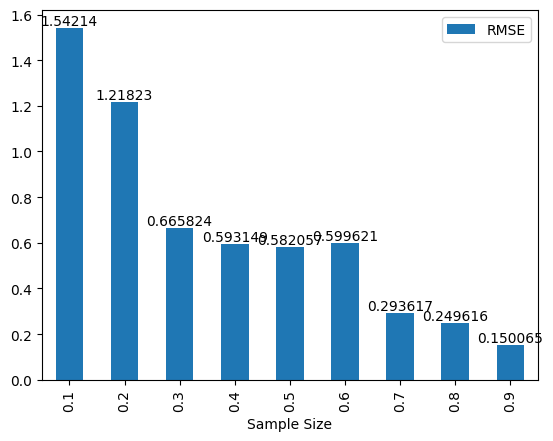

C:\Users\MMadi\AppData\Local\Temp\ipykernel_14044\28121194.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = trips.groupby('s2').apply(lambda x: x.sample(frac = sampling_frequency)).reset_index(drop=True)
C:\Users\MMadi\AppData\Local\Temp\ipykernel_14044\28121194.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = trips.groupby('s2').apply(lambda x: x.sample(frac = 

<Figure size 640x480 with 0 Axes>

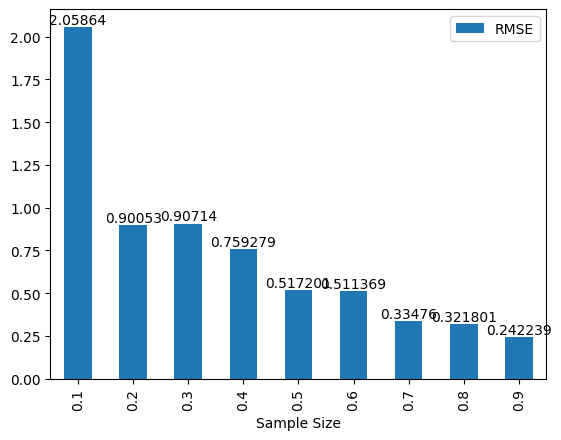

C:\Users\MMadi\AppData\Local\Temp\ipykernel_14044\28121194.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = trips.groupby('s2').apply(lambda x: x.sample(frac = sampling_frequency)).reset_index(drop=True)
C:\Users\MMadi\AppData\Local\Temp\ipykernel_14044\28121194.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = trips.groupby('s2').apply(lambda x: x.sample(frac = 

<Figure size 640x480 with 0 Axes>

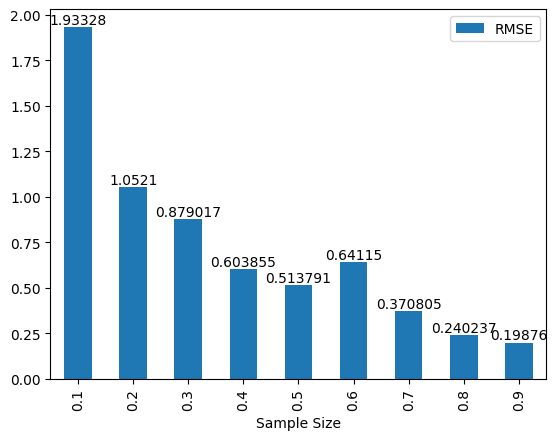

C:\Users\MMadi\AppData\Local\Temp\ipykernel_14044\28121194.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = trips.groupby('s2').apply(lambda x: x.sample(frac = sampling_frequency)).reset_index(drop=True)
C:\Users\MMadi\AppData\Local\Temp\ipykernel_14044\28121194.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = trips.groupby('s2').apply(lambda x: x.sample(frac = 

<Figure size 640x480 with 0 Axes>

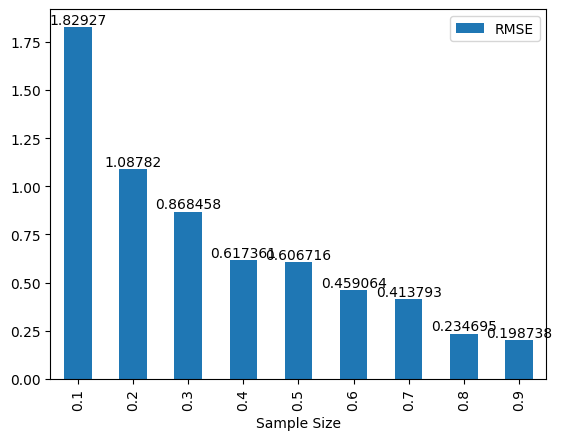

C:\Users\MMadi\AppData\Local\Temp\ipykernel_14044\28121194.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = trips.groupby('s2').apply(lambda x: x.sample(frac = sampling_frequency)).reset_index(drop=True)
C:\Users\MMadi\AppData\Local\Temp\ipykernel_14044\28121194.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = trips.groupby('s2').apply(lambda x: x.sample(frac = 

<Figure size 640x480 with 0 Axes>

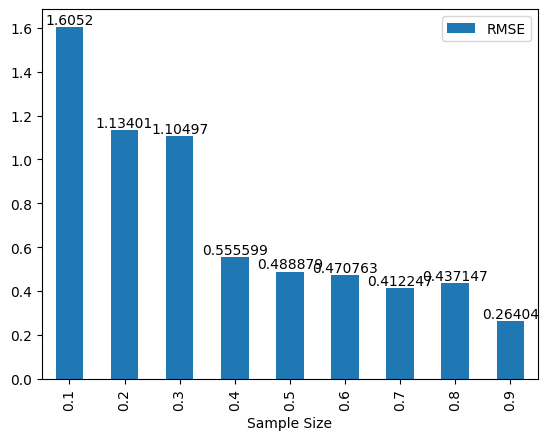

[[1.542137065892303, 1.2182294472438948, 0.665823755880591, 0.5931487324041703, 0.5820566850268329, 0.5996213419985038, 0.29361661072330797, 0.2496162034371664, 0.15006497709157351], [2.0586408853889338, 0.9005298939965254, 0.9071404023629297, 0.7592790523047362, 0.5172010311629779, 0.5113690516015533, 0.3347596592962891, 0.3218006762571216, 0.2422390271878829], [1.933276518567597, 1.0521044348688984, 0.879017368482623, 0.6038552083780471, 0.5137906713485431, 0.6411502271200309, 0.3708050146145891, 0.2402369843190215, 0.198759621891026], [1.8292684274854896, 1.0878193347121268, 0.8684583334244721, 0.6173610283660689, 0.6067158699728437, 0.45906449645858133, 0.41379294941173456, 0.23469507292801325, 0.19873817236204183], [1.6052006523319349, 1.1340113745796656, 1.1049738343400093, 0.5555990658545764, 0.4888790410248103, 0.470762873867757, 0.41224723963474114, 0.4371473413280992, 0.2640404565602377]]


In [12]:
errors = []
for _ in range(5):
    error = perform_test()
    errors.append(error)
print(errors)

We see that when the S2 resolution is fixed to 14, the error dramatically decreases at sampling size 0.4, and then slowly decreases as we increase the sample size.

## <font color = 'blue'> Fixed Size and Variable Resolution </font>

### <font color = 'green'>- RMSE </font>

In [13]:
s2_resolution_min = 0
s2_resolution_max = 30
sampling_frequency = 0.6

In [14]:
def group_by_s2(df, s2_resolution):
    df['s2'] = df.apply(lambda x: s2.geo_to_s2(x.Pickup_latitude, x.Pickup_longitude, s2_resolution), axis=1)
    return df.groupby('s2')

In [15]:
def perform_test():
    error = []
    s2_resolution = s2_resolution_min
    while s2_resolution <= s2_resolution_max:
        stratified_sample = group_by_s2(trips, s2_resolution).apply(lambda x: x.sample(frac = sampling_frequency)).reset_index(drop=True)
        random_sample_pm25 = (stratified_sample
                    .groupby('neighborhood')
                    .Total_amount
                    .agg(list)
                    .to_frame("Total_amount_list")
                    .reset_index())  # Make a list of pm25 values for each neighborhood
        random_sample_pm25['Overall_amount'] = random_sample_pm25['Total_amount_list'].apply(lambda x: sum(x))  # Find the average pm25 value per neighborhood
        random_sample_pm25.drop('Total_amount_list', axis = 1, inplace=True)
        max_values = random_sample_pm25['Overall_amount'].max()
        random_sample_pm25['Overall_amount'] *= 1000
        random_sample_pm25['Overall_amount'] /= max_values
        for neighborhood in population_pm25["neighborhood"]:
            if neighborhood not in random_sample_pm25["neighborhood"].values:
                random_sample_pm25.loc[len(random_sample_pm25.index)] = [neighborhood, 0]
        random_sample_pm25.sort_values(by='neighborhood', inplace=True)
        random_sample_pm25.reset_index(drop=True, inplace=True)
        assert population_pm25['neighborhood'].equals(random_sample_pm25['neighborhood'])
        baseline_pm25 =    population_pm25["Overall_amount"].values
        sampled_pm25  = random_sample_pm25["Overall_amount"].values
        rmse = calculate_rmse(sampled_pm25, baseline_pm25)
        error.append(rmse)
        s2_resolution += 1
    S2_Performance = pd.DataFrame({'S2 Resolution':list(range(s2_resolution_min, s2_resolution_max + 1)),
                                'RMSE': error})
    plt.figure()
    ax = S2_Performance.plot(kind='bar', x='S2 Resolution', y= 'RMSE')
    ax.bar_label(ax.containers[0], color = 'black')
    plt.show()
    return error

C:\Users\MMadi\AppData\Local\Temp\ipykernel_14044\4123074686.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = group_by_s2(trips, s2_resolution).apply(lambda x: x.sample(frac = sampling_frequency)).reset_index(drop=True)
C:\Users\MMadi\AppData\Local\Temp\ipykernel_14044\4123074686.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = group_by_s2(trips, s2_resolution).

<Figure size 640x480 with 0 Axes>

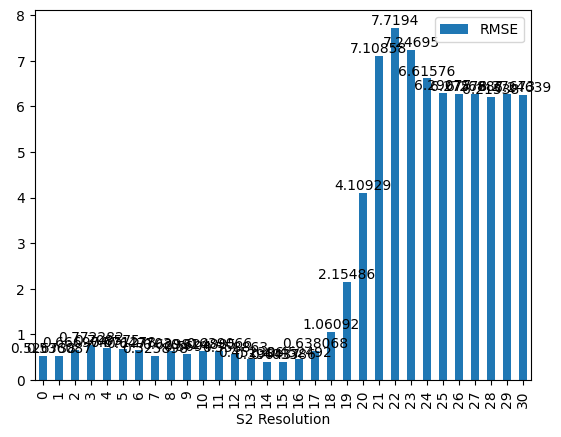

C:\Users\MMadi\AppData\Local\Temp\ipykernel_14044\4123074686.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = group_by_s2(trips, s2_resolution).apply(lambda x: x.sample(frac = sampling_frequency)).reset_index(drop=True)
C:\Users\MMadi\AppData\Local\Temp\ipykernel_14044\4123074686.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = group_by_s2(trips, s2_resolution).

<Figure size 640x480 with 0 Axes>

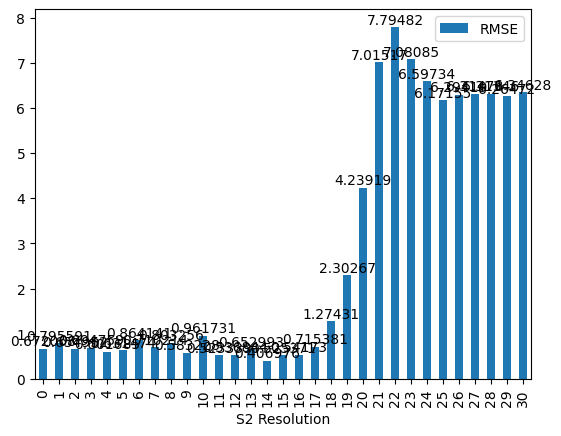

C:\Users\MMadi\AppData\Local\Temp\ipykernel_14044\4123074686.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = group_by_s2(trips, s2_resolution).apply(lambda x: x.sample(frac = sampling_frequency)).reset_index(drop=True)
C:\Users\MMadi\AppData\Local\Temp\ipykernel_14044\4123074686.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = group_by_s2(trips, s2_resolution).

<Figure size 640x480 with 0 Axes>

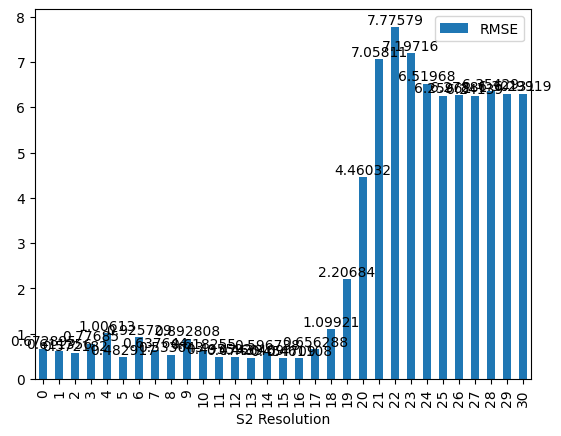

C:\Users\MMadi\AppData\Local\Temp\ipykernel_14044\4123074686.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = group_by_s2(trips, s2_resolution).apply(lambda x: x.sample(frac = sampling_frequency)).reset_index(drop=True)
C:\Users\MMadi\AppData\Local\Temp\ipykernel_14044\4123074686.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = group_by_s2(trips, s2_resolution).

<Figure size 640x480 with 0 Axes>

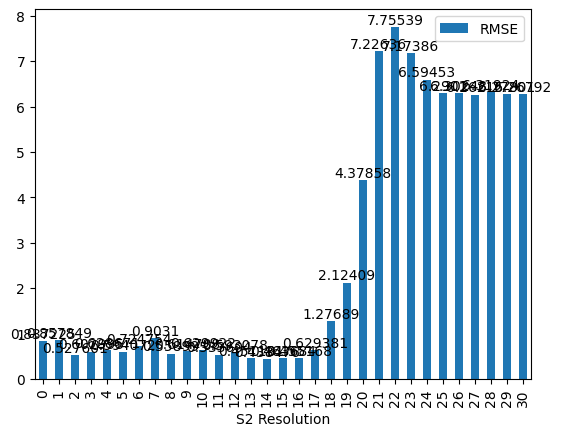

C:\Users\MMadi\AppData\Local\Temp\ipykernel_14044\4123074686.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = group_by_s2(trips, s2_resolution).apply(lambda x: x.sample(frac = sampling_frequency)).reset_index(drop=True)
C:\Users\MMadi\AppData\Local\Temp\ipykernel_14044\4123074686.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  stratified_sample = group_by_s2(trips, s2_resolution).

<Figure size 640x480 with 0 Axes>

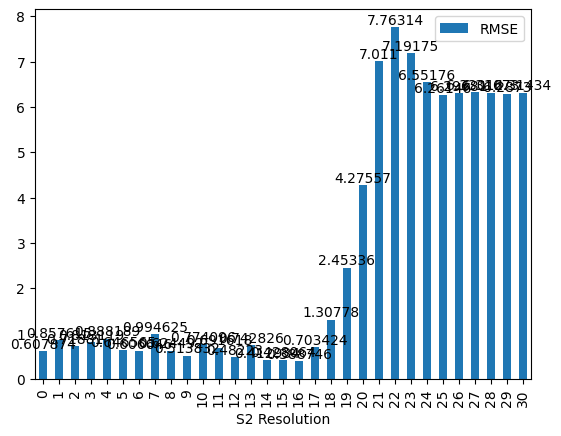

[[0.5267380934965878, 0.5360866853089092, 0.6669737843101476, 0.7722815975659009, 0.708575449888701, 0.6712778008851658, 0.6477026535627998, 0.5258984303875407, 0.6299102861240566, 0.569400366346172, 0.6248851794407964, 0.6390664799767158, 0.5588628909880151, 0.45239577564327094, 0.3964369822277352, 0.4033861466284431, 0.45249166817695535, 0.6380676843162647, 1.0609225070641615, 2.1548580963903365, 4.109292312661917, 7.108577872159612, 7.719403267341555, 7.246949015727774, 6.6157588765549935, 6.290768095877989, 6.275775052030362, 6.268874648896029, 6.215379338644524, 6.276727648253335, 6.246389895942282], [0.6720675396433373, 0.7955907190544801, 0.6549518381369381, 0.6947593139523011, 0.6016847857011961, 0.6314739679464442, 0.8641408847107871, 0.7102139368304675, 0.8032555056975041, 0.58322806549096, 0.9617311579134539, 0.5233389598211708, 0.536843814053617, 0.6529932153243382, 0.4069762696586241, 0.5253707782721635, 0.5417298990909034, 0.7153810365211735, 1.2743138054983107, 2.3026715

In [16]:
errors = []
for _ in range(5):
    error = perform_test()
    errors.append(error)
print(errors)

With a fixed sampling size of 0.6, the error spikes at resolution 18, and it dramatically increases, reaching its peak error at resolution 22. For resolutions below 18, the error is small and almost constant.